# Hugging Face Accelerate!

Supercharge your pytorch training loop with Accelerate!

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset('glue', 'mrpc')
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'],
                     truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['idx', 'sentence1', 'sentence2'])
tokenized_datasets = tokenized_datasets.rename_column('label',"labels")
tokenized_datasets = tokenized_datasets.with_format('torch')

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

'''Grab a batch of data and inspect it, check to see if everything
works as intended'''

for batch in train_dataloader:
    break
print({k: v.shape for k, v in batch.items()})

'''Send the training data to the model'''
from transformers import AutoModelForSequenceClassification

checkpoint = 'bert-base-cased'
# Adjust number of labels to the number of classes, in this case 2
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

'''To be sure everything is going well, check outputs'''
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)
# Note: The transformers model automatically calculates the loss

'''So, just initialize the optimizer and the training loop'''
# optimizer:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=0.005)

# training loop:
loss = outputs.loss
loss.backward()
optimizer.step()

optimizer.zero_grad()

'''To reduce learning rate to 0 import get_scheduler
This is a convenient function from the transformers library to 
progressively decay our learning rate to zero as we train the model'''

from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps 
)

'''Device agnostic code: use gpu'''
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]), 'input_ids': torch.Size([8, 70]), 'token_type_ids': torch.Size([8, 70]), 'attention_mask': torch.Size([8, 70])}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor(0.7182, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


cpu


Normally, we'd just do the training loop as follows:

In [ ]:
# '''Finally, we can put everything together:'''

# from tqdm.auto import tqdm

# progress_bar = tqdm(range(num_training_steps))

# # set model to training mode:
# model.train()
# for epoch in range(num_epochs):
#     # loop over batches:
#     for batch in train_dataloader:
#         # send batch to device:
#         batch = {k: v.to(device) for k,v in batch.items()}
#         # forward pass:
#         outputs = model(**batch)
#         # calculate loss:
#         loss = outputs.loss
#         loss.backward()
#         # update weights:
#         optimizer.step()
#         # update learning rate:
#         lr_scheduler.step()
#         # reset gradients:
#         optimizer.zero_grad()
#         # update progress bar:
#         progress_bar.update(1)


But with accelerate you just make a few changes:

In [ ]:
# You won't need to uncomment the commented lines! 
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader
)

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        # loss.backward()
        accelerator.backward(loss)
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Once you trained, know that 
Accelerate also handles distributed evaluation!

In [6]:
from datasets import load_metric

metric = load_metric('glue', 'mrpc')
model.eval()

from accelerate import Accelerator
accelerator = Accelerator()

eval_dataloader = accelerator.prepare(eval_dataloader)
for batch in eval_dataloader:
    # batch = {k: v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=predictions, references=batch['labels'])
    metric.add_batch(
        predictions=accelerator.gather(predictions), references=accelerator.gather(batch['labels'])
    )
    
metric.compute()

{'accuracy': 0.3161764705882353, 'f1': 0.0}

The distributed training script has to be launched several times in different processes.
However, with accelerate,
you get to configure your setup easily and launch a training script
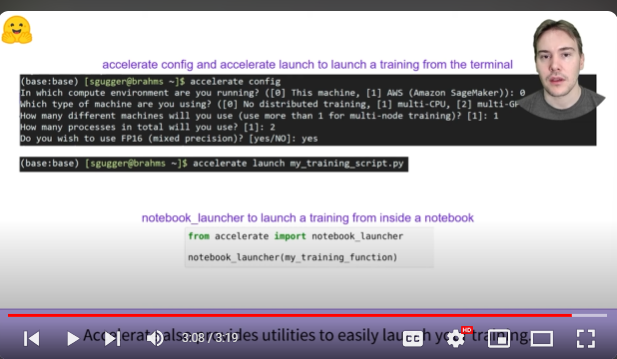

You could use a notebook launcher function to launch your training in a notebook

In [ ]:
from accelerate import notebook_launcher

notebook_launcher(my_training_function)